## Python Script to Convert Coordinates Between Projections

In [ ]:
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import rioxarray as rxr

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:

ds = xr.open_dataset("DATA_DIR/SAR_composite_2025001T0000_2025001T2359_NP06_1km_nrcs.nc", engine='netcdf4')
ds

<xarray.Dataset> Size: 484MB
Dimensions:     (time: 1, level: 1, y: 10998, x: 10998)
Coordinates:
  * time        (time) datetime64[ns] 8B 2025-01-01T23:59:59
  * level       (level) uint8 1B 0
  * x           (x) float32 44kB -5.499e+06 -5.498e+06 ... 5.497e+06 5.498e+06
  * y           (y) float32 44kB -5.499e+06 -5.498e+06 ... 5.497e+06 5.498e+06
Data variables:
    NRCS        (time, level, y, x) float32 484MB ...
    projection  uint32 4B ...
Attributes: (12/57)
    Conventions:                CF-1.6, ACCD-1.3
    source:                     SENTINEL-1A/1B, RADARSAT-2, and RADARSAT Cont...
    institution:                NOAA/NESDIS/STAR/SOCD
    history:                    02 January 2025 14:00Z: NetCDF file generated...
    title:                      SAR Normalized Radar Cross Section Arctic Com...
    references:                 Synthetic Aperture Radar Marine Users Manual....
    ...                         ...
    cw:gctp_zone:               0
    cw:gctp_parm:               [        0.         0.         0.         0. ...
    cw:gctp_datum:              12
    cw:software_name:           SAR Operational Product System
    cw:software_version:        3
    cw:et_affine:               [ 0.00000e+00  1.00000e+03  1.00000e+03  0.00...

In [4]:
# Check if crs attribute is set.
# returns None.  
print(ds.rio.crs)

None


## Get projection metadata and set it to the data set

In [ ]:
# Extract WKT string from the datafile
spatial_ref = ds['projection'].attrs.get('spatial_ref')

# Set the CRS for ds
ds = ds.rio.write_crs(spatial_ref, inplace=True)

# returns wkt
print(ds.rio.crs)

PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]


## Display data on the polar map

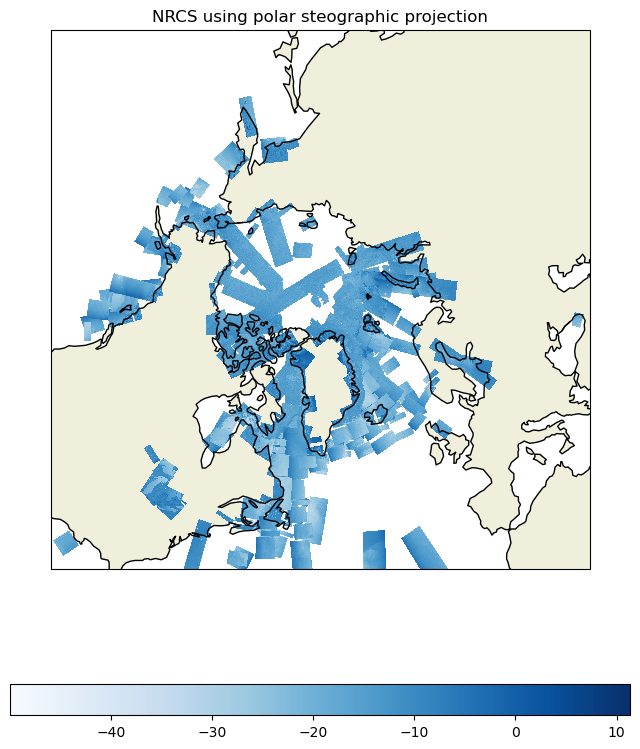

In [ ]:
# proj4string from metadata
#  +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +u

# Define crs
crs_epsg = ccrs.NorthPolarStereo(
    central_longitude=-45,
    true_scale_latitude=60)

# Set figure size
fig = plt.figure(figsize=[10, 10])

# Set the map projection 
ax = plt.axes(projection = crs_epsg)
ax.coastlines()
ax.add_feature(cfeature.LAND)

# Set the data crs using 'transform' 
cs = ax.pcolormesh(ds['x'], ds['y'], ds['NRCS'][0][0] , 
                   cmap=plt.cm.Blues,  transform= crs_epsg)  
fig.colorbar(cs, ax=ax, location='bottom', shrink =0.8)
ax.set_title('NRCS using polar steographic projection')

plt.show()

## Convert coordinates to EPSG:4326 (lat and lon)

In [ ]:
# Convert ds to epsg:4326
ds_latlon = ds['NRCS'][0].rio.reproject("EPSG:4326")

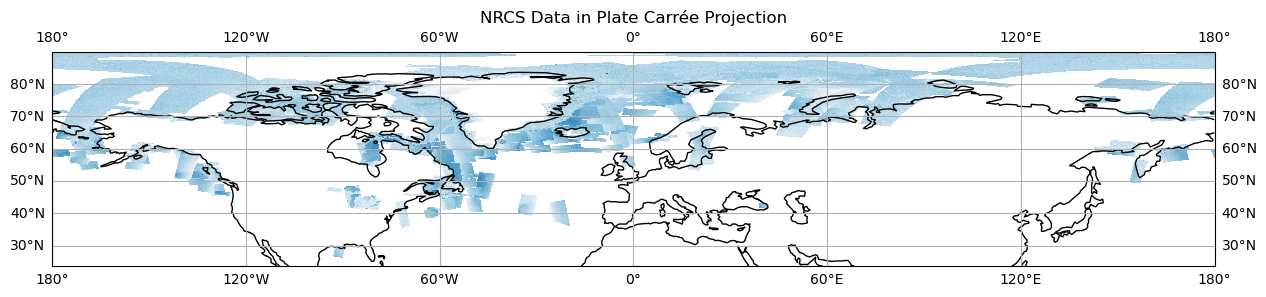

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ds_latlon.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Tell Cartopy data is in lat/lon
    # cmap='viridis'
     add_colorbar=False
)

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("NRCS Data in Plate Carree Projection")
plt.show()

In [ ]:
# Verifying conversion with corner data

# polar streographic values of min/max
x0, x1 = ds['x'].values[[0, -1]]
y0, y1 = ds['y'].values[[0, -1]]

print("Polar (Original) corner coordinates (x, y):")
print(f" Bottom-left:  ({x0:.2f}, {y0:.2f})")
print(f" Top-right:    ({x1:.2f}, {y1:.2f})")

# lat/lon values of min/max
lon0, lon1 = ds_latlon['x'].values[[0, -1]]
lat0, lat1 = ds_latlon['y'].values[[0, -1]]

print("Reprojected corner coordinates (lon, lat):")
print(f" Bottom-left (SW):     ({lon0:.6f}, {lat0:.6f})")
print(f" Top-right (NE):     ({lon1:.6f}, {lat1:.6f})")

# with the (0,0) at north pole, the data seem correct, expanding from -180 to 180 (lon) and about 24 to 90 (lat)

Polar (Original) corner coordinates (x, y):
 Bottom-left:  (-5498550.00, -5498550.00)
 Top-right:    (5498450.00, 5498450.00)
Reprojected corner coordinates (lon, lat):
 Bottom-left (SW):     (-179.988232, 89.988232)
 Top-right (NE):     (179.988232, 23.664435)
